In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mase', 'rsq'])

# Model 1

## Train/Test Split

In [3]:
df = pd.read_csv('multivar.csv') 
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [4]:
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)

In [5]:
df = df.sort_index()
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(1416, 67) (607, 67)


In [6]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1416, 66) (1416,) (607, 66) (607,)


## Model 

In [7]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[16:49:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:2227.16797	validation_1-rmse:432.45697
[1]	validation_0-rmse:1610.21521	validation_1-rmse:312.27222
[2]	validation_0-rmse:1168.11243	validation_1-rmse:230.85245
[3]	validation_0-rmse:852.93750	validation_1-rmse:174.66794
[4]	validation_0-rmse:628.38776	validation_1-rmse:132.82042
[5]	validation_0-rmse:465.20743	validation_1-rmse:105.86253
[6]	validation_0-rmse:346.60538	validation_1-rmse:88.00558
[7]	validation_0-rmse:260.64362	validation_1-rmse:76.91593
[8]	validation_0-rmse:197.94604	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

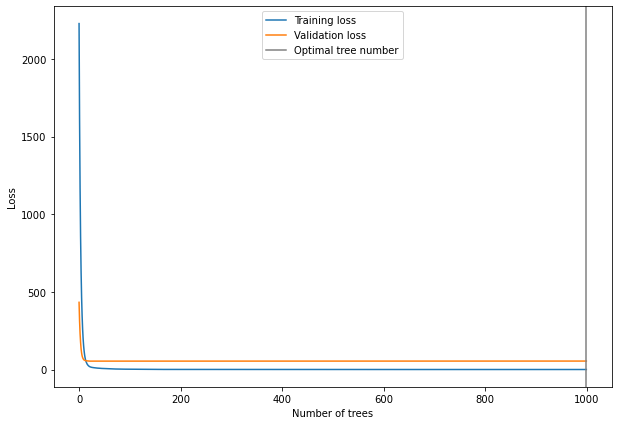

In [8]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [9]:
reg.best_iteration

999

## Feature Importance

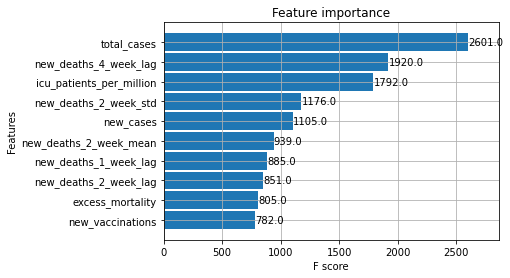

In [10]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

## Forcast on Test Set

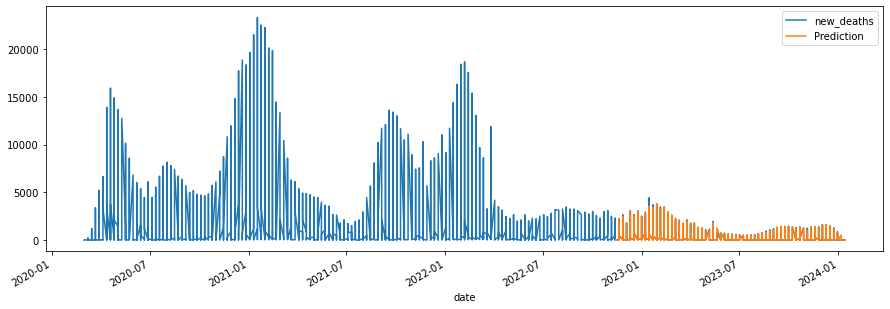

In [11]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

## Metrics

In [12]:
y_val = test[['new_deaths']].copy()
y_val.sort_index(inplace=True)
y_pred = test['Prediction'].squeeze() 
y_pred.sort_index(inplace=True)
y_train_df = train[['new_deaths']].copy()
y_train_df.sort_index(inplace=True)

In [13]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(y_val, y_pred, y_train = y_train_df)
r2 = r2_score(test['new_deaths'], test['Prediction'])
new_row = {'model': 'Baseline', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Model 2

## Train/Test Split

In [15]:
df = pd.read_csv('multivar.csv') 
df = df[['total_cases', 'new_deaths_4_week_lag', 'icu_patients_per_million', 'new_deaths_2_week_std', 'new_cases', 
         'new_deaths_2_week_mean', 'new_deaths_1_week_lag', 'new_deaths_2_week_lag', 'excess_mortality', 'new_vaccinations',
         'date', 'new_deaths', 'location']]
categorical_cols = ['location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [16]:
df = df.sort_index()
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(1416, 21) (607, 21)


In [17]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1416, 20) (1416,) (607, 20) (607,)


## Model

In [18]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[19:41:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:2228.11255	validation_1-rmse:428.87805
[1]	validation_0-rmse:1612.58166	validation_1-rmse:308.84451
[2]	validation_0-rmse:1174.47803	validation_1-rmse:225.41858
[3]	validation_0-rmse:863.12878	validation_1-rmse:168.05263


[4]	validation_0-rmse:642.36823	validation_1-rmse:134.76390
[5]	validation_0-rmse:483.26498	validation_1-rmse:115.82498
[6]	validation_0-rmse:367.78268	validation_1-rmse:95.02767
[7]	validation_0-rmse:282.66104	validation_1-rmse:86.85296
[8]	validation_0-rmse:219.90358	validation_1-rmse:83.71051
[9]	validation_0-rmse:174.13129	validation_1-rmse:80.08163
[10]	validation_0-rmse:139.26474	validation_1-rmse:78.49035
[11]	validation_0-rmse:112.99236	validation_1-rmse:77.64527
[12]	validation_0-rmse:92.02402	validation_1-rmse:75.36830
[13]	validation_0-rmse:76.49400	validation_1-rmse:73.58427
[14]	validation_0-rmse:64.74641	validation_1-rmse:73.08968
[15]	validation_0-rmse:56.18605	validation_1-rmse:71.80244
[16]	validation_0-rmse:49.51234	validation_1-rmse:70.72185
[17]	validation_0-rmse:44.76291	validation_1-rmse:70.26560
[18]	validation_0-rmse:40.47567	validation_1-rmse:70.25816
[19]	validation_0-rmse:37.27452	validation_1-rmse:69.82886
[20]	validation_0-rmse:34.78266	validation_1-rmse:69

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

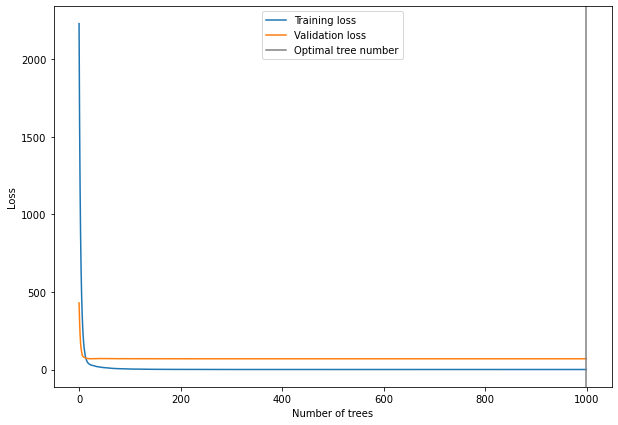

In [19]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [20]:
reg.best_iteration

999

## Forcast on Test Set

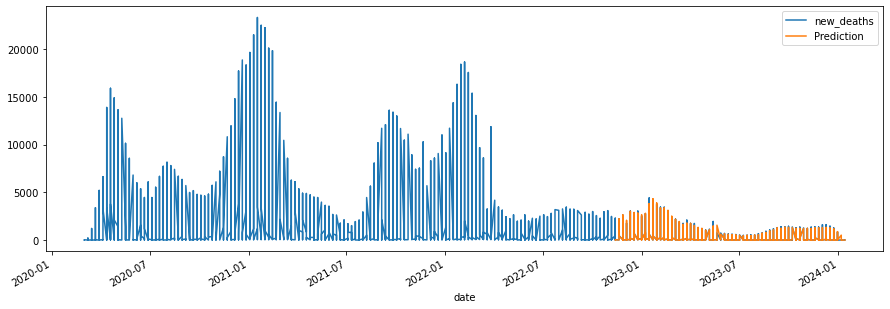

In [21]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

## Metrics

In [22]:
y_val = test[['new_deaths']].copy()
y_val.sort_index(inplace=True)
y_pred = test['Prediction'].squeeze() 
y_pred.sort_index(inplace=True)
y_train_df = train[['new_deaths']].copy()
y_train_df.sort_index(inplace=True)

In [23]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
r2 = r2_score(test['new_deaths'], test['Prediction'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(y_val, y_pred, y_train = y_train_df)
new_row = {'model': 'Top 10 Features', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

In [25]:
metrics

,model,mae,mase,rsq
0,Baseline,12.489878,0.007106,0.99069
1,Top 10 Features,18.846561,0.010722,0.984939


# Model 3

## Cross-Validation

In [26]:
df = pd.read_csv('multivar.csv') 
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

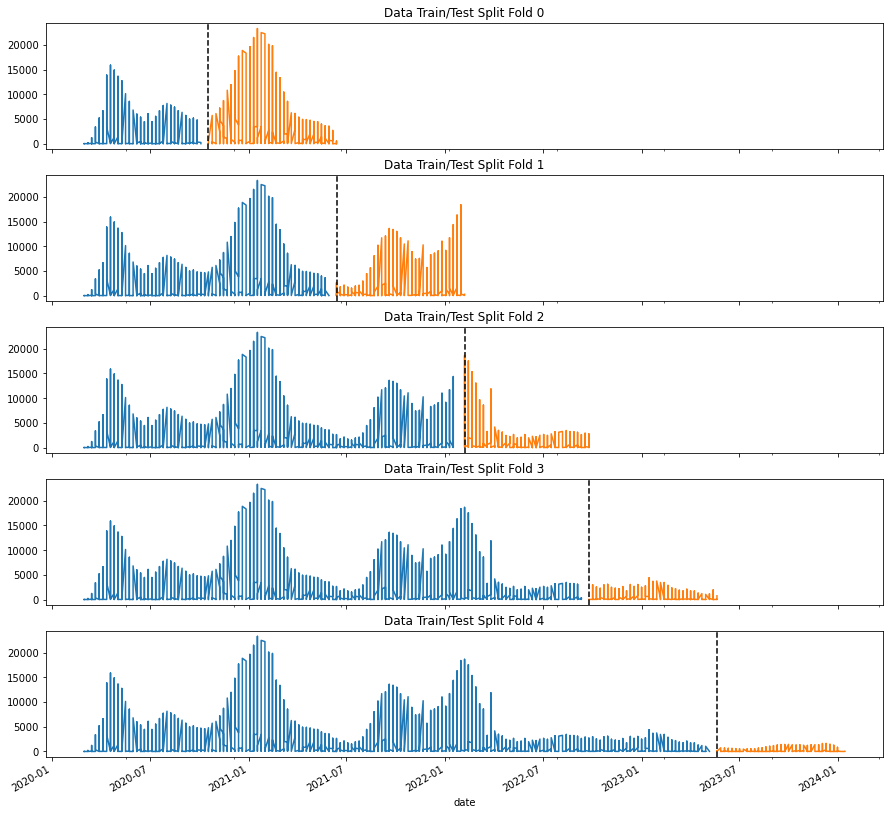

In [27]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 2023 // (5 + 1), gap = 24)
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['new_deaths'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['new_deaths'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [28]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train.drop(columns=['new_deaths']) 
    X_test = test.drop(columns=['new_deaths']) 
    y_train = train['new_deaths']
    y_test = test['new_deaths']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=20,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)  

[19:45:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:2577.99438	validation_1-rmse:4309.77539


[100]	validation_0-rmse:1091.74231	validation_1-rmse:2456.87451
[200]	validation_0-rmse:485.18652	validation_1-rmse:1727.41980
[300]	validation_0-rmse:232.80631	validation_1-rmse:1417.82056
[400]	validation_0-rmse:123.15733	validation_1-rmse:1245.35303
[500]	validation_0-rmse:74.14511	validation_1-rmse:1196.39893
[600]	validation_0-rmse:49.28435	validation_1-rmse:1175.22144
[700]	validation_0-rmse:35.73823	validation_1-rmse:1163.61389
[800]	validation_0-rmse:28.16446	validation_1-rmse:1156.61414
[900]	validation_0-rmse:23.27991	validation_1-rmse:1151.43860
[999]	validation_0-rmse:19.94471	validation_1-rmse:1147.92615
[19:45:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:57

In [29]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 395.2592
Fold scores:[1147.9261766853442, 309.28972816004347, 451.51750876753897, 41.21213648930973, 26.350637977058927]


## Retrain 

In [32]:
df = df.sort_index()
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=100)

(1416, 66) (1416,) (607, 66) (607,)
[19:46:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3061.00317	validation_1-rmse:597.48767


[100]	validation_0-rmse:1224.82398	validation_1-rmse:247.68541
[200]	validation_0-rmse:522.46625	validation_1-rmse:114.11022
[300]	validation_0-rmse:249.43028	validation_1-rmse:75.62463
[400]	validation_0-rmse:141.35455	validation_1-rmse:64.78175
[500]	validation_0-rmse:94.93935	validation_1-rmse:53.37138
[600]	validation_0-rmse:72.74741	validation_1-rmse:44.38038
[700]	validation_0-rmse:60.90928	validation_1-rmse:39.12172
[800]	validation_0-rmse:54.72086	validation_1-rmse:35.64055
[900]	validation_0-rmse:50.94413	validation_1-rmse:34.17314
[999]	validation_0-rmse:46.74009	validation_1-rmse:33.15437


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

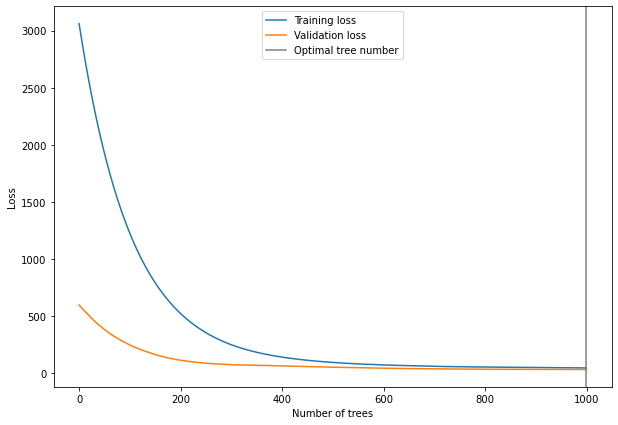

In [33]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [34]:
reg.best_iteration

999

## Forcast on Test Set

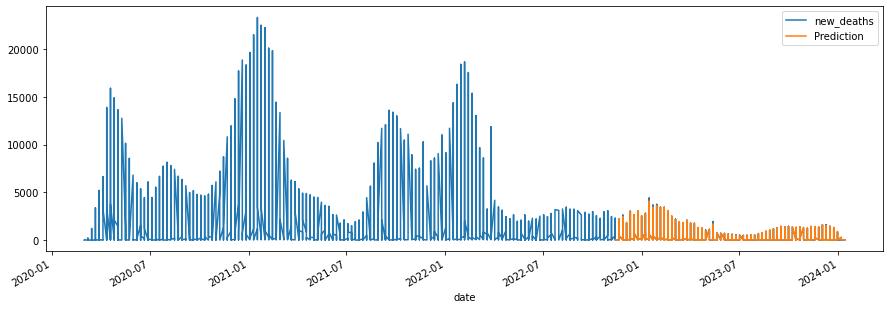

In [35]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

## Metrics

In [36]:
y_val = test[['new_deaths']].copy()
y_val.sort_index(inplace=True)
y_pred = test['Prediction'].squeeze() 
y_pred.sort_index(inplace=True)
y_train_df = train[['new_deaths']].copy()
y_train_df.sort_index(inplace=True)

In [37]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
r2 = r2_score(test['new_deaths'], test['Prediction'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(y_val, y_pred, y_train = y_train_df)
new_row = {'model': 'Cross-Validation', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [17]:
metrics.sort_values('mase')

,model,mae,mase,rsq
